In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import numpy as np
import pandas as pd
import os
import re

from fastai.vision import *
from fastai import *

In [3]:
path = Path('/home/jupyter/insight_project/Project-M/data/raw')
filenames = path.ls()
filenames.remove(Path('/home/jupyter/insight_project/Project-M/data/raw/raw_data.txt'))
len(filenames)

71

In [4]:
with open(filenames[0]) as file:
    data = json.load(file)

In [5]:
len(data['data_points'][1]['embedding'])

768

In [6]:
body, label, source, emb = [], [], [], []
with open(filenames[0]) as file:
    data = json.load(file)
for item in data['data_points']:
    body.append(item['body'])
    label.append(item['label'])
    source.append(item['source'])
    emb.append(item['embedding'])
df = pd.DataFrame(list(zip(body, label, source, emb)),
                     columns = ['Body', 'Label', 'Source', 'Emb'])

In [7]:
df['Label'].value_counts()

0    149
1     73
Name: Label, dtype: int64

In [8]:
df.head()

,Body,Label,Source,Emb
0,@desperosolace @yu_malaya I agree! It's ridicu...,1,twitter,"[0.22415, -0.0983968, 0.380258, -0.170204, 0.1..."
1,@yu_malaya it's total BS!!! i hate this so muc...,1,twitter,"[0.298532, -0.673054, 0.206383, 0.0876255, 0.2..."
2,@owedbetter_ I wanted to withdraw my applicati...,1,twitter,"[-0.215192, -0.722328, 0.343752, -0.305405, 0...."
3,Good question. My situation was a bit differen...,0,reddit,"[0.0647961, -0.201043, 0.235075, -0.241841, 0...."
4,"""Like me, you can also achieve your IELTS band...",0,twitter,"[0.0020502, -0.629544, 0.299081, -0.0883578, 0..."


In [9]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,Body,Label,Source,Emb
0,"@onlyjungmo wtf, its twitter not ielts or anyt...",0,twitter,"[0.284056, -0.801095, 0.13843, 0.0463759, -0.2..."
1,So my parents just told me to look for postgra...,1,twitter,"[-0.176495, -0.851798, 0.0101, -0.166101, 0.47..."
2,\&gt; I was wondering what advice you might ha...,0,reddit,"[-0.199485, -0.207016, -0.124386, -0.191996, -..."
3,udh semingguan diajakin main mata sama mba2 ef...,0,twitter,"[-0.209483, -0.617773, 0.0310961, -0.104769, 0..."
4,I can only use words to convey this and that's...,0,reddit,"[0.210019, 0.0631881, 0.271043, 0.0633598, -0...."


In [10]:
i = round(df.shape[0] * 0.7)
df_train = df[:i]
df_valid = df[i:]

In [11]:
df_train['Label'].value_counts()

0    110
1     45
Name: Label, dtype: int64

In [12]:
df_valid['Label'].value_counts()

0    39
1    28
Name: Label, dtype: int64

In [14]:
#Test cell
test_item = (df.iloc[3]['Body'],
             df.iloc[3]['Label'],
             df.iloc[3]['Emb'])

In [17]:
torch.tensor(test_item[1])

tensor(0)

In [8]:
class SiameseDataset(Dataset):
    def __init__(self,df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,i):
        same = lambda : random.randint(0,1) #construct same pair or different pair
        return self.siameseItem(i,same())
    
    def siameseItem(self,i,same):
        _label = self.df.iloc[i]['Label']
        if same:
            same_label_list = np.where(self.df['Label'] == _label)[0]
            if len(same_label_list) > 1: #have more than 1 items, then don't pick itself
                same_label_list = np.delete(same_label_list,np.argwhere(same_label_list==i))
            msg_index = same_label_list[np.random.randint(0,len(same_label_list))] #pick another msg
        else:
            diff_label_list = np.where(self.df['Label'] != _label)[0]
            msg_index = diff_label_list[np.random.randint(0,len(diff_label_list))]
        return self.constructSiamese(i,msg_index,same)
    
    def constructSiamese(self,item_1_idx,item_2_idx,same):
        item_1 = (torch.tensor(self.df.iloc[item_1_idx]['Emb']),
                  torch.tensor(self.df.iloc[item_1_idx]['Label'])
                 )
        item_2 = (torch.tensor(self.df.iloc[item_2_idx]['Emb']),
                  torch.tensor(self.df.iloc[item_2_idx]['Label'])
                  )
        return ([item_1,item_2],same)

In [9]:
df['fn'] = df.index
df.head()

,Body,Label,Source,Emb,fn
0,@desperosolace @yu_malaya I agree! It's ridicu...,1,twitter,"[0.22415, -0.0983968, 0.380258, -0.170204, 0.1...",0
1,@yu_malaya it's total BS!!! i hate this so muc...,1,twitter,"[0.298532, -0.673054, 0.206383, 0.0876255, 0.2...",1
2,@owedbetter_ I wanted to withdraw my applicati...,1,twitter,"[-0.215192, -0.722328, 0.343752, -0.305405, 0....",2
3,Good question. My situation was a bit differen...,0,reddit,"[0.0647961, -0.201043, 0.235075, -0.241841, 0....",3
4,"""Like me, you can also achieve your IELTS band...",0,twitter,"[0.0020502, -0.629544, 0.299081, -0.0883578, 0...",4


In [28]:
torch.tensor(df[df['fn'].values == 0]['Emb'].values[0]).shape

torch.Size([768])

In [29]:
class EmbeddingItemList(ImageList):
    def open(self,fn):
        regex = re.compile(r'\d+')
        fn = re.findall(regex,fn)
        df = self.inner_df[self.inner_df['fn'].values == int(fn[0])] #single row
        return torch.tensor(df['Emb'].values[0])

In [13]:
df.head()

,Body,Label,Source,Emb
0,@desperosolace @yu_malaya I agree! It's ridicu...,1,twitter,"[0.22415, -0.0983968, 0.380258, -0.170204, 0.1..."
1,@yu_malaya it's total BS!!! i hate this so muc...,1,twitter,"[0.298532, -0.673054, 0.206383, 0.0876255, 0.2..."
2,@owedbetter_ I wanted to withdraw my applicati...,1,twitter,"[-0.215192, -0.722328, 0.343752, -0.305405, 0...."
3,Good question. My situation was a bit differen...,0,reddit,"[0.0647961, -0.201043, 0.235075, -0.241841, 0...."
4,"""Like me, you can also achieve your IELTS band...",0,twitter,"[0.0020502, -0.629544, 0.299081, -0.0883578, 0..."


In [30]:
data = (EmbeddingItemList
        .from_df(df,path=path,cols='fn')
        .split_by_rand_pct(0.3,seed=42)
        .label_from_df(cols='Label')
       )

In [35]:
data.train.inner_df['Label'].value_counts()

0    103
1     53
Name: Label, dtype: int64

In [37]:
data.valid.inner_df['Label'].value_counts()

0    46
1    20
Name: Label, dtype: int64

In [38]:
train_dl = DataLoader(
    dataset = SiameseDataset(data.train.inner_df),
    batch_size = 16,
    shuffle = True,
    num_workers = 0
)

valid_dl = DataLoader(
    dataset = SiameseDataset(data.valid.inner_df),
    batch_size = 16,
    num_workers = 0
)

In [39]:
data = ImageDataBunch(train_dl,valid_dl)

In [40]:
x, y = next(iter(data.train_dl))

# Understand the data

input x: 
1. a tuple of 2 items, 
2. x[0] x[1] a tuple of 3 items
3. x[0][0], x[1][0], body of message
4. x[0][1], x[1][1], label of the item for each in df
5. x[0][2], x[1][2], emb of the item for each in df

y, siamese indicator, 0 means diff, 1 means same

Note: x[0][0],and x[0][1], body and label list are used for debugging. 

Model should only train on embedding 

In [41]:
len(x),len(y)

(2, 16)

In [42]:
len(x[0]),len(x[1])

(2, 2)

In [43]:
len(x[0][0])

16

In [44]:
x[0][1][0],x[1][1][0],y[0] 
#check labels,
#item_1 has label 1, item_2 has label 0, siamese ground truth has label 0

(tensor(0), tensor(0), tensor(1))

In [45]:
x[0][0][0].shape,x[1][0][0].shape

(torch.Size([768]), torch.Size([768]))

In [46]:
x[0][0].shape,x[1][0].shape

(torch.Size([16, 768]), torch.Size([16, 768]))

In [121]:
class SiameseNet(nn.Module):
    def __init__(self,f_size):
        super().__init__()
        self.size = f_size
        self.linear = nn.Linear(self.size,1,bias=True)
        
    def forward(self,*xb):
        #print(xb)
        emb_1,emb_2 = self.get_Image_Batch(xb)
        distance = (emb_1 - emb_2).abs_()
        #distance = F.pairwise_distance(emb_1,emb_2)
        return self.linear(distance.float())
    
    def get_Image_Batch(self,xb): return xb[0][0],xb[1][0]

In [122]:
model = SiameseNet(768)

In [123]:
learn = Learner(data,model,loss_func=BCEWithLogitsFlat())

In [124]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 4.37E-04


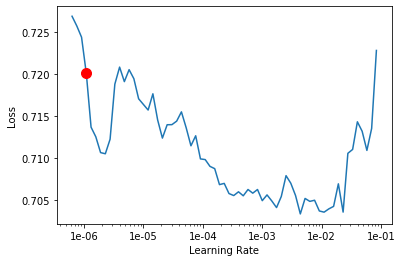

In [125]:
learn.recorder.plot(suggestion=True,skip_end=15)

In [126]:
learn.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,time
0,0.723609,0.716584,00:00
1,0.715276,0.696089,00:00
2,0.711462,0.715083,00:00
3,0.705284,0.696167,00:00
4,0.700662,0.696940,00:00
5,0.697797,0.676557,00:00
6,0.694314,0.695321,00:00
7,0.694880,0.705621,00:00
8,0.694248,0.692006,00:00
9,0.693390,0.695971,00:00


In [34]:
preds = model(x)

In [35]:
preds.shape

torch.Size([16, 1])

In [40]:
preds

tensor([[-0.3481],
        [-0.4289],
        [-0.5623],
        [-0.4056],
        [-0.1649],
        [-0.2686],
        [-0.3722],
        [-0.3888],
        [-0.1886],
        [-0.2015],
        [-0.0709],
        [-0.2238],
        [-0.5076],
        [-0.3619],
        [-0.2527],
        [-0.8882]], grad_fn=<AddmmBackward>)

In [41]:
BCEWithLogitsFlat()(preds,y)

tensor(0.7120, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)